In [1]:
#https://www.kaggle.com/code/taronzakaryan/predicting-stock-price-using-lstm-model-pytorch/notebook

In [260]:
import numpy as np
import random
import pandas as pd 
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

from pandas import datetime
import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable


import os
for dirname, _, filenames in os.walk('input'):
    for i, filename in enumerate(filenames):
        if i<5:
            print(os.path.join(dirname,filename))

input/.DS_Store
input/aadr.us.txt
input/aame.us.txt
input/aaap.us.txt


/var/folders/jw/61jjk4jd69sbkflvlpjrlv1h0000gn/T/ipykernel_12914/2152648851.py:9: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [261]:
## Load data

In [262]:
def stocks_data(symbols, dates):
    df = pd.DataFrame(index=dates)
    for symbol in symbols:
        df_temp = pd.read_csv("input/aadr.us.txt".format(symbol), index_col='Date',
                parse_dates=True, usecols=['Date', 'Close'], na_values=['nan'])
        df_temp = df_temp.rename(columns={'Close': symbol})
        df = df.join(df_temp)
    return df

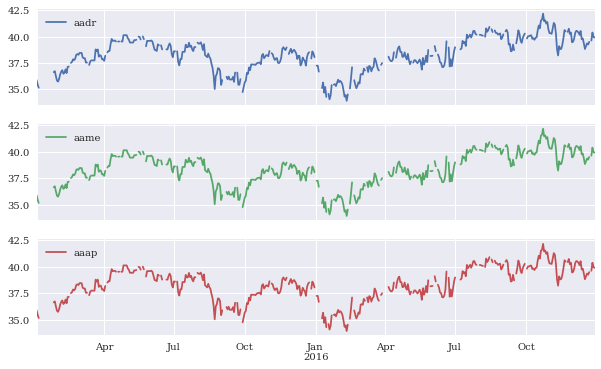

In [263]:
dates = pd.date_range('2015-01-02','2016-12-31',freq='B')
symbols = ['aadr','aame','aaap']
df = stocks_data(symbols, dates)
df.fillna(method='pad')
df.plot(figsize=(10, 6), subplots=True);

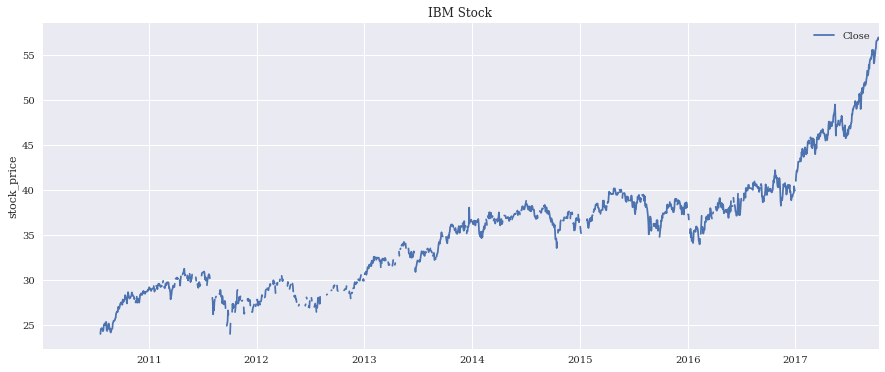

In [264]:
dates = pd.date_range('2010-01-02','2017-10-11',freq='B')
df1=pd.DataFrame(index=dates)
df_ibm=pd.read_csv("input/aadr.us.txt", parse_dates=True, index_col=0)
df_ibm=df1.join(df_ibm)
df_ibm[['Close']].plot(figsize=(15, 6))
plt.ylabel("stock_price")
plt.title("IBM Stock")
plt.show()

In [265]:
df.head()

,aadr,aame,aaap
2015-01-02,35.894,35.894,35.894
2015-01-05,35.454,35.454,35.454
2015-01-06,35.158,35.158,35.158
2015-01-07,NaN,NaN,NaN
2015-01-08,35.708,35.708,35.708


In [266]:
df_ibm.dropna(axis=0, inplace=True)
df_ibm

,Open,High,Low,Close,Volume,OpenInt
2010-07-21,24.333,24.333,23.9460,23.946,43321.0,0.0
2010-07-22,24.644,24.644,24.3620,24.487,18031.0,0.0
2010-07-23,24.759,24.759,24.3140,24.507,8897.0,0.0
2010-07-26,24.624,24.624,24.4490,24.595,19443.0,0.0
2010-07-27,24.477,24.517,24.4310,24.517,8456.0,0.0
...,...,...,...,...,...,...
2017-10-05,56.770,56.870,56.5500,56.590,31169.0,0.0
2017-10-06,56.410,56.710,56.3548,56.710,19862.0,0.0
2017-10-09,56.890,56.900,56.5900,56.710,47436.0,0.0
2017-10-10,57.010,57.090,56.7400,56.940,31755.0,0.0


In [267]:
df_ibm=df_ibm.fillna(method='ffill')
df_ibm

,Open,High,Low,Close,Volume,OpenInt
2010-07-21,24.333,24.333,23.9460,23.946,43321.0,0.0
2010-07-22,24.644,24.644,24.3620,24.487,18031.0,0.0
2010-07-23,24.759,24.759,24.3140,24.507,8897.0,0.0
2010-07-26,24.624,24.624,24.4490,24.595,19443.0,0.0
2010-07-27,24.477,24.517,24.4310,24.517,8456.0,0.0
...,...,...,...,...,...,...
2017-10-05,56.770,56.870,56.5500,56.590,31169.0,0.0
2017-10-06,56.410,56.710,56.3548,56.710,19862.0,0.0
2017-10-09,56.890,56.900,56.5900,56.710,47436.0,0.0
2017-10-10,57.010,57.090,56.7400,56.940,31755.0,0.0


In [268]:
df_ibm=df_ibm.fillna(method='ffill')

scaler = MinMaxScaler(feature_range=(-1, 1))
df_ibm['Close'] = scaler.fit_transform(df_ibm['Close'].values.reshape(-1,1))
#df_ibm = scaler.fit_transform(df_ibm['Close'].values.reshape(-1,1))
df_ibm

,Open,High,Low,Close,Volume,OpenInt
2010-07-21,24.333,24.333,23.9460,-1.000000,43321.0,0.0
2010-07-22,24.644,24.644,24.3620,-0.967206,18031.0,0.0
2010-07-23,24.759,24.759,24.3140,-0.965994,8897.0,0.0
2010-07-26,24.624,24.624,24.4490,-0.960660,19443.0,0.0
2010-07-27,24.477,24.517,24.4310,-0.965388,8456.0,0.0
...,...,...,...,...,...,...
2017-10-05,56.770,56.870,56.5500,0.978784,31169.0,0.0
2017-10-06,56.410,56.710,56.3548,0.986058,19862.0,0.0
2017-10-09,56.890,56.900,56.5900,0.986058,47436.0,0.0
2017-10-10,57.010,57.090,56.7400,1.000000,31755.0,0.0


In [269]:
df_ibm["Close"] = scaler.fit_transform(df_ibm['Close'].values.reshape(-1,1))
df_ibm =df_ibm[["Close"]]

In [270]:
df_ibm

,Close
2010-07-21,-1.000000
2010-07-22,-0.967206
2010-07-23,-0.965994
2010-07-26,-0.960660
2010-07-27,-0.965388
...,...
2017-10-05,0.978784
2017-10-06,0.986058
2017-10-09,0.986058
2017-10-10,1.000000


In [271]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

look_back = 10 # choose sequence length
x_train, y_train, x_test, y_test = load_data(df_ibm, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (1226, 9, 1)
y_train.shape =  (1226, 1)
x_test.shape =  (307, 9, 1)
y_test.shape =  (307, 1)


In [272]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [283]:
data_raw = df_ibm.values

data = []

# create all possible sequences of length look_back
for index in range(len(data_raw) - look_back): 
    data.append(data_raw[index: index + look_back])

In [284]:
data

[array([[-1.        ],
        [-0.96720616],
        [-0.96599382],
        [-0.96065951],
        [-0.96538765],
        [-0.97060072],
        [-0.9812087 ],
        [-0.97654119],
        [-0.94586895],
        [-0.93356368]]),
 array([[-0.96720616],
        [-0.96599382],
        [-0.96065951],
        [-0.96538765],
        [-0.97060072],
        [-0.9812087 ],
        [-0.97654119],
        [-0.94586895],
        [-0.93356368],
        [-0.93192702]]),
 array([[-0.96599382],
        [-0.96065951],
        [-0.96538765],
        [-0.97060072],
        [-0.9812087 ],
        [-0.97654119],
        [-0.94586895],
        [-0.93356368],
        [-0.93192702],
        [-0.92895678]]),
 array([[-0.96065951],
        [-0.96538765],
        [-0.97060072],
        [-0.9812087 ],
        [-0.97654119],
        [-0.94586895],
        [-0.93356368],
        [-0.93192702],
        [-0.92895678],
        [-0.94059526]]),
 array([[-0.96538765],
        [-0.97060072],
        [-0.9812087 ],
   

In [286]:
df_ibm.head(20)

,Close
2010-07-21,-1.000000
2010-07-22,-0.967206
2010-07-23,-0.965994
2010-07-26,-0.960660
2010-07-27,-0.965388
2010-07-28,-0.970601
2010-07-29,-0.981209
2010-07-30,-0.976541
2010-08-02,-0.945869
2010-08-03,-0.933564


In [274]:
# Build model
#####################
input_dim = 1
hidden_dim = 80 #32
num_layers = 4 #2
output_dim = 1


# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out
    
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 80, num_layers=4, batch_first=True)
  (fc): Linear(in_features=80, out_features=1, bias=True)
)
18
torch.Size([320, 1])
torch.Size([320, 80])
torch.Size([320])
torch.Size([320])
torch.Size([320, 80])
torch.Size([320, 80])
torch.Size([320])
torch.Size([320])
torch.Size([320, 80])
torch.Size([320, 80])
torch.Size([320])
torch.Size([320])
torch.Size([320, 80])
torch.Size([320, 80])
torch.Size([320])
torch.Size([320])
torch.Size([1, 80])
torch.Size([1])


In [275]:
# Train model
#####################
num_epochs = 100
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()


Epoch  10 MSE:  0.12331859767436981
Epoch  20 MSE:  0.07154904305934906
Epoch  30 MSE:  0.06841792911291122
Epoch  40 MSE:  0.05779527872800827
Epoch  50 MSE:  0.011661099269986153
Epoch  60 MSE:  0.009972857311367989
Epoch  70 MSE:  0.007064067292958498
Epoch  80 MSE:  0.003362224204465747
Epoch  90 MSE:  0.002028827555477619


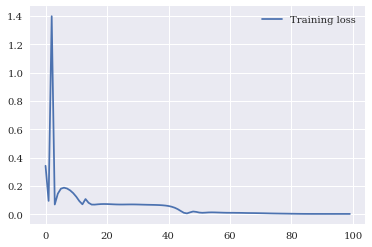

In [276]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()


In [277]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.04 RMSE
Test Score: 0.32 RMSE


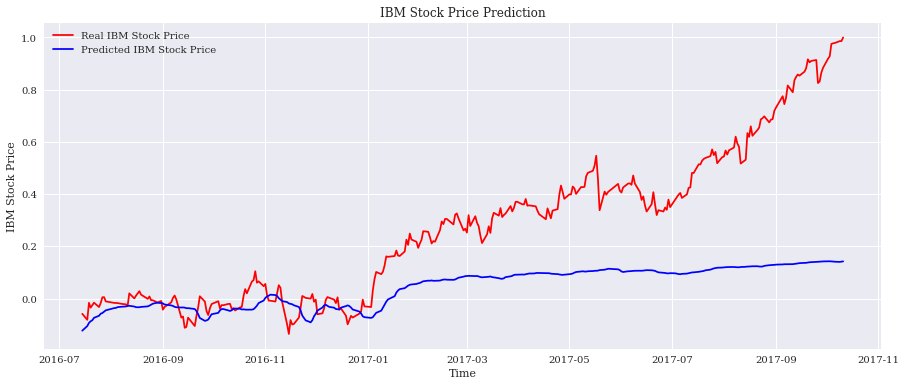

In [278]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(df_ibm[len(df_ibm)-len(y_test):].index, y_test, color = 'red', label = 'Real IBM Stock Price')
axes.plot(df_ibm[len(df_ibm)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted IBM Stock Price')
#axes.xticks(np.arange(0,394,50))
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price')
plt.legend()
plt.savefig('ibm_pred.png')
plt.show()